In [1]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

from wxdata import radar, geog

import matplotlib.pyplot as plt
%matplotlib inline

%env WORKDIR ~/Documents/weatherpy-work

env: WORKDIR=~/Documents/weatherpy-work


In [2]:
order = radar.OrderLevel2()
selection = order.select_around('KVNX', '2012-04-15 00:27')
selection.items

['2012/04/15/KVNX/KVNX20120415_002743_V06.gz']

In [3]:
file = selection[0].download()[0]

In [22]:
import pyart
sample = pyart.io.read_nexrad_archive(file)

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 01:57:10.716656. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 02:02:07.292396. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


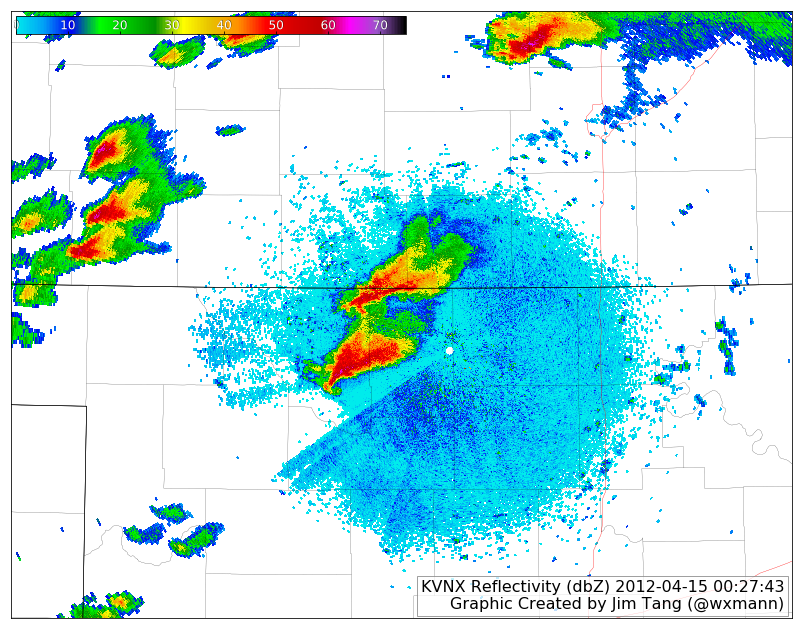

In [28]:
fig0 = plt.figure(figsize=(14, 14))
_, display0 = radar.plot_level2(sample, 'reflectivity', sweep=0, 
                                zoom_km=(180, 140), shift_latlon=(0.15, -0.25))

from wxdata.plotting import bottom_right_textbox, inset_colorbar
timestamp = radar.timestamp_from_filename(file)

title = 'KVNX Reflectivity (dbZ) {}\nGraphic Created by Jim Tang (@wxmann)'.format(
    timestamp.strftime('%Y-%m-%d %H:%M:%S'))

bottom_right_textbox(display0.basemap.ax, title)
inset_colorbar(display0.plots[0], display0.basemap.ax, tickcolor='white', loc=2, width='50%')

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-31 23:27:54.790314. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


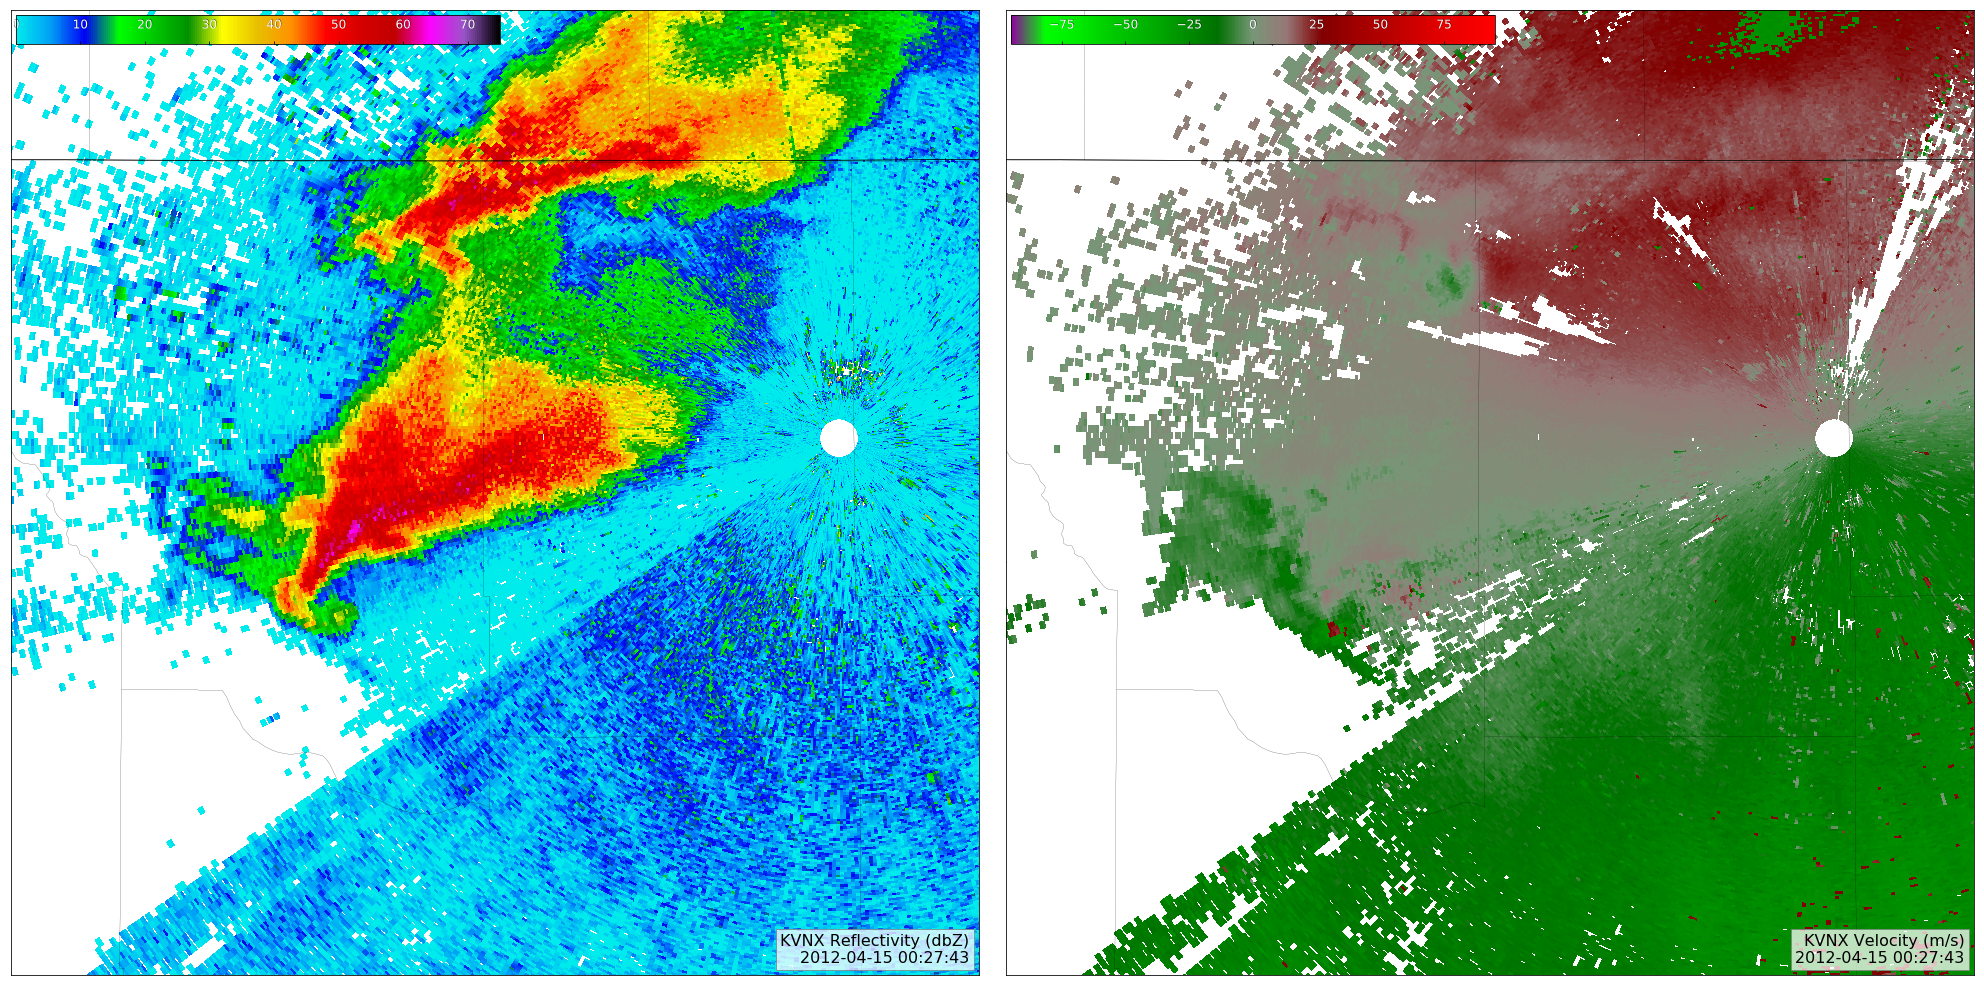

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(28, 14))
plt.tight_layout()

# zoom used to be (120, 100)
sample, display1 = radar.plot_level2(sample, 'reflectivity', sweep=0, zoom_km=(60, 50), 
                                    shift_latlon=(-0.05, -0.4), ax=ax1)

sample, display2 = radar.plot_level2(sample, 'velocity', sweep=1,
                                     basemap=display1.basemap, ax=ax2)

from wxdata.plotting import bottom_right_textbox, inset_colorbar
timestamp = radar.timestamp_from_filename(file).strftime('%Y-%m-%d %H:%M:%S')

title_ref = 'KVNX Reflectivity (dbZ)\n{}'.format(timestamp)
title_vel = 'KVNX Velocity (m/s)\n{}'.format(timestamp)

bottom_right_textbox(ax1, title_ref)
bottom_right_textbox(ax2, title_vel)
inset_colorbar(display1.plots[0], ax1, tickcolor='white', loc=2, width='50%')
inset_colorbar(display2.plots[0], ax2, tickcolor='white', loc=2, width='50%')